In [1]:
import os
# TYPE="Default" #Default, or other custom foldername
TYPE="MyFoler"
isWINDOWS=True
if "Default"==TYPE:
    ROOT_FOLDER="Default"
    LABEL_MAPPING=dict(enumerate([str(i) for i in range(10)]))
    
else:
    ROOT_FOLDER=TYPE
    LABEL_MAPPING=dict(enumerate(["down", "left", "ok", "right", "up"]))
    
#-------Data    
RAW_DATASET_FOLDER=os.path.join(ROOT_FOLDER, "raw_dataset")

#-------Train
VAL_FOLDER=os.path.join(ROOT_FOLDER, "validation")
TRAIN_FOLDER=os.path.join(ROOT_FOLDER, "train")
TEST_FOLDER=os.path.join(ROOT_FOLDER, "test")
CHECK_POINT_FOLDER=os.path.join(ROOT_FOLDER, "checkpoints")

#-------Model
SAVED_MODEL_FILENAME = "saved_model"
FLOAT_TFL_MODEL_FILENAME = "float_model.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model.tfl"
TFL_CC_MODEL_FILENAME = "magic_wand_model_data.cc"

SAVED_MODEL_PATH=os.path.join(ROOT_FOLDER, SAVED_MODEL_FILENAME)
FLOAT_TFL_MODEL_PATH=os.path.join(ROOT_FOLDER, FLOAT_TFL_MODEL_FILENAME)
QUANTIZED_TFL_MODEL_PATH=os.path.join(ROOT_FOLDER, QUANTIZED_TFL_MODEL_FILENAME)
TFL_CC_MODEL_PATH=os.path.join(ROOT_FOLDER, TFL_CC_MODEL_FILENAME)

In [2]:
###############################################
## download json data ("Default"==TYPE only)
###############################################
import shutil

if "Default"==TYPE:
    os.makedirs(ROOT_FOLDER, exist_ok=True)
    zipfile=ROOT_FOLDER + os.sep + "__magic_wand_digit_data.zip"
    !curl -L https://github.com/petewarden/magic_wand_digit_data/archive/8170591863f9addca27b1a963263f7c7bed33f41.zip -o {zipfile}
    try:
        shutil.rmtree(os.path.join(ROOT_FOLDER, "magic_wand_digit_data-8170591863f9addca27b1a963263f7c7bed33f41"))
    except:
        pass
    if isWINDOWS:
        # ! forfiles /P .{os.sep}{ROOT_FOLDER}{os.sep} /M magic_wand_digit_data* /C "cmd /c if @isdir==TRUE rmdir /s /q @file"
        !tar -xf {zipfile} -C {ROOT_FOLDER}{os.sep} && del /Q {zipfile}
    else:
        !unzip {zipfile} -d {ROOT_FOLDER}{os.sep} && rm -f {zipfile}
    try:
        shutil.rmtree(RAW_DATASET_FOLDER)
    except:
        pass

    os.rename(os.path.join(ROOT_FOLDER, "magic_wand_digit_data-8170591863f9addca27b1a963263f7c7bed33f41"), RAW_DATASET_FOLDER)
    try:
        shutil.rmtree(CHECK_POINT_FOLDER)
    except:
        pass
    
    os.makedirs(CHECK_POINT_FOLDER, exist_ok=True)
else:
    print("Nothing here")

Nothing here


In [3]:
###############################################
## prepare json data ("Default"!=TYPE only)
###############################################

import shutil
if "Default"!=TYPE:
    os.makedirs(ROOT_FOLDER, exist_ok=True)
    os.makedirs(RAW_DATASET_FOLDER, exist_ok=True)
    os.makedirs(CHECK_POINT_FOLDER, exist_ok=True)
    print(f"Please manually copy json to {RAW_DATASET_FOLDER}, don't forget to modify \"label\":\"\" in json files ")
else:
    print("Nothing here")

Please manually copy json to MyFoler\raw_dataset, don't forget to modify "label":"" in json files 


In [4]:
###############################################
## Load all *.json
###############################################
import glob
import json

strokes = []
for filename in glob.glob(RAW_DATASET_FOLDER+os.sep+"*.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes.append(stroke)

In [5]:
## (Optional) print stroke
import matplotlib.pyplot as plt

def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(24, 6))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

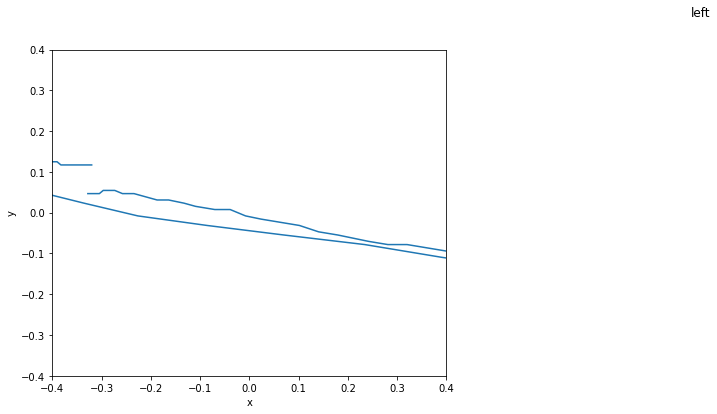

This stroke: 77
All strokes: min 46 max 108 avg 65.34352517985612


In [6]:
## (Optional) print stroke
import numpy as np
shuffled_strokes = list(strokes)
np.random.shuffle(shuffled_strokes)
plot_stroke(shuffled_strokes[0])
print(f"This stroke: {len(shuffled_strokes[0]['strokePoints'])}")
func = lambda x: len(x["strokePoints"])
values = list(map(func, strokes))
print(f"All strokes: min {np.min(values)} max {np.max(values)} avg {np.average(values)}")

In [7]:
###############################################
## Add stroke sequence color
###############################################
import math
import numpy as np
import PIL

FIXED_POINT = 4096

def mul_fp(a, b):
  return (a * b) // FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) // b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

# 四捨五入 (rounding)
def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT // len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    # This just want to add a Gradient color
    # red->green->blue
    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    #  mainly horizontal
    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    #  mainly vertical
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue
  
  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

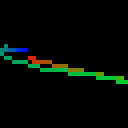

In [8]:
## (Optional) test rasterize_stroke
raster = rasterize_stroke(shuffled_strokes[0]["strokePoints"], 0.5, 0.5, 32, 32)
img = PIL.Image.fromarray(raster).resize((128, 128), PIL.Image.NEAREST)
display(img)

In [9]:
###############################################
## function def: save strokes (and augmentations) data to png
###############################################
from pathlib import Path
import shutil

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

# Augmentation
def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      # Note: no move augmentation as the stroke should be more or less
      # centered within the raster
      augmented_points = augment_points(points, 0.0, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))


In [10]:
###############################################
## Separate all strokes data to 3 png folders (The json is from ../magic_wand/website/index.html)
###############################################
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = list(strokes)
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

print("preparing data...", TEST_FOLDER)
save_strokes_as_images(test_strokes, TEST_FOLDER, IMAGE_WIDTH, IMAGE_HEIGHT, 10)
print("preparing data...", VAL_FOLDER)
save_strokes_as_images(validation_strokes, VAL_FOLDER, IMAGE_WIDTH, IMAGE_HEIGHT, 0)
print("preparing data...", TRAIN_FOLDER)
save_strokes_as_images(train_strokes, TRAIN_FOLDER, IMAGE_WIDTH, IMAGE_HEIGHT, 10)

preparing data... MyFoler\test
preparing data... MyFoler\validation
preparing data... MyFoler\train


In [11]:
###############################################
## Setup dataset with keras tool
###############################################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

validation_ds = image_dataset_from_directory(
    directory=VAL_FOLDER,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory=TRAIN_FOLDER,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)


Found 55 files belonging to 5 classes.
Found 4906 files belonging to 5 classes.


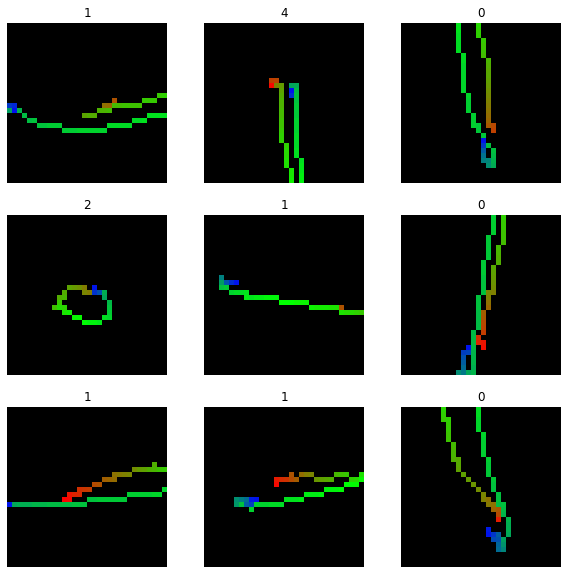

In [12]:
## (Optional) test dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    ax.set_title(f"{np.argmax(labels[i])}")
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
from keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

Training model with 5 classes


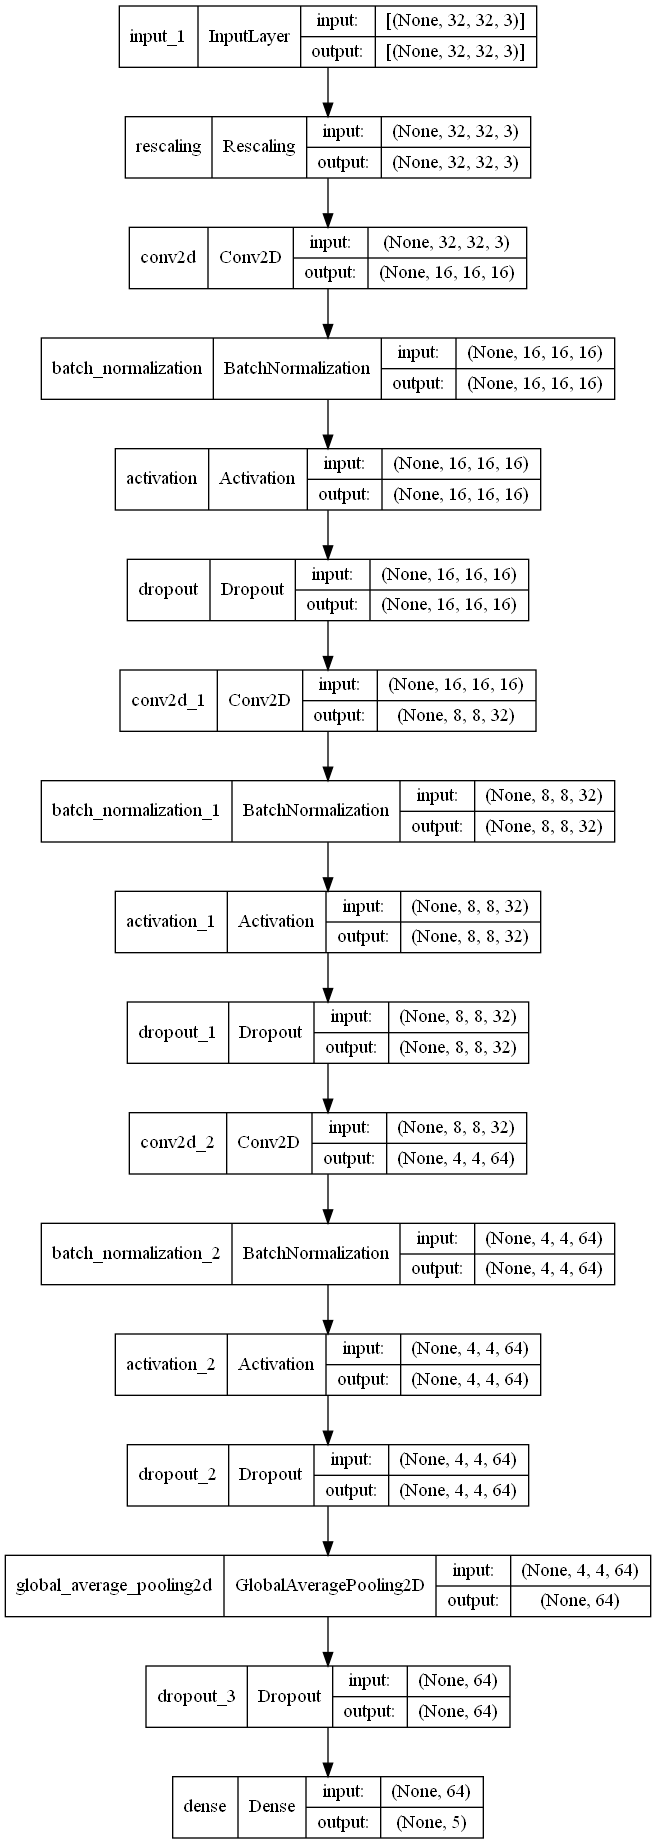

In [14]:
# num_classes=len(glob.glob(TRAIN_FOLDER+os.sep+"*"+os.sep)) # list class numbers (by dir count)
# print(f"Training model with {num_classes} classes")
print(f"Training model with {len(LABEL_MAPPING)} classes")

model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=len(LABEL_MAPPING))
keras.utils.plot_model(model, show_shapes=True)

In [15]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(CHECK_POINT_FOLDER,"save_at_{epoch}.h5")),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds,
)

Epoch 1/30
154/154 [==============================] - 2s 11ms/step - loss: 0.5252 - accuracy: 0.3094 - val_loss: 0.5307 - val_accuracy: 0.3273
Epoch 2/30
154/154 [==============================] - 2s 10ms/step - loss: 0.3883 - accuracy: 0.4951 - val_loss: 0.4759 - val_accuracy: 0.4545
Epoch 3/30
154/154 [==============================] - 2s 10ms/step - loss: 0.3515 - accuracy: 0.5473 - val_loss: 0.3656 - val_accuracy: 0.5818
Epoch 4/30
154/154 [==============================] - 2s 10ms/step - loss: 0.3253 - accuracy: 0.5942 - val_loss: 0.3126 - val_accuracy: 0.6727
Epoch 5/30
154/154 [==============================] - 2s 10ms/step - loss: 0.3036 - accuracy: 0.6380 - val_loss: 0.2792 - val_accuracy: 0.7091
Epoch 6/30
154/154 [==============================] - 2s 10ms/step - loss: 0.2854 - accuracy: 0.6802 - val_loss: 0.2632 - val_accuracy: 0.7273
Epoch 7/30
154/154 [==============================] - 2s 10ms/step - loss: 0.2684 - accuracy: 0.7087 - val_loss: 0.2240 - val_accuracy: 0.8182

In [16]:
def predict_image(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)


In [17]:
index, score = predict_image(model, os.path.join(TEST_FOLDER,LABEL_MAPPING[0],"2.png"))
print("predict:", index, "score:", score*100)

predict: 0 score: 99.55739974975586


In [18]:
from IPython.display import Image, display
import os
def calc_score(model, predict_fn, testfolder):
    SCORE_THRESHOLD = 0.75

    correct_count = 0
    wrong_count = 0
    discarded_count = 0

    for label_dir in glob.glob(os.path.join(testfolder,"*")+os.sep):
      # print(label_dir)  # "Default\test\0", "Default\test\1"
      label = label_dir.replace(testfolder+os.sep, "").replace(os.sep,"")
      for filename in glob.glob(label_dir +os.sep+ "*.png"):
        index, score = predict_fn(model, filename)
        if score < SCORE_THRESHOLD:
          discarded_count += 1
          continue
        if LABEL_MAPPING[index] == label:
          correct_count += 1
        else:
          wrong_count += 1
          print("%s expected, %s(%d) found with score %f (%s)" % (label, LABEL_MAPPING[index], index, score, filename))
          display(Image(filename=filename, width = 100, height = 100))

    correct_percentage = (correct_count / (correct_count + wrong_count)) * 100
    print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

MyFoler\test
down expected, ok(2) found with score 0.963431 (MyFoler\test\down\6_a1.png)


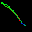

right expected, left(1) found with score 0.914090 (MyFoler\test\right\5_a5.png)


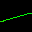

right expected, left(1) found with score 0.898333 (MyFoler\test\right\5_a7.png)


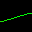

99.5% correct (N=586, 19 unknown)
MyFoler\validation
100.0% correct (N=52, 3 unknown)
MyFoler\train
down expected, up(4) found with score 0.844231 (MyFoler\train\down\13_a0.png)


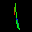

down expected, up(4) found with score 0.806503 (MyFoler\train\down\13_a1.png)


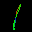

down expected, up(4) found with score 0.817342 (MyFoler\train\down\13_a6.png)


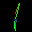

down expected, ok(2) found with score 0.973556 (MyFoler\train\down\45_a6.png)


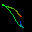

left expected, ok(2) found with score 0.756773 (MyFoler\train\left\102_a2.png)


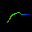

left expected, ok(2) found with score 0.803587 (MyFoler\train\left\102_a9.png)


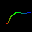

left expected, right(3) found with score 0.784518 (MyFoler\train\left\49_a0.png)


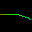

left expected, right(3) found with score 0.779061 (MyFoler\train\left\49_a9.png)


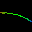

right expected, left(1) found with score 0.831281 (MyFoler\train\right\28_a1.png)


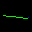

right expected, left(1) found with score 0.786968 (MyFoler\train\right\28_a5.png)


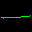

right expected, left(1) found with score 0.840874 (MyFoler\train\right\46.png)


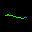

right expected, left(1) found with score 0.865740 (MyFoler\train\right\46_a0.png)


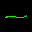

right expected, left(1) found with score 0.850235 (MyFoler\train\right\46_a4.png)


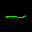

right expected, left(1) found with score 0.818906 (MyFoler\train\right\46_a7.png)


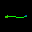

right expected, left(1) found with score 0.853409 (MyFoler\train\right\46_a8.png)


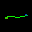

right expected, left(1) found with score 0.870299 (MyFoler\train\right\46_a9.png)


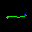

right expected, ok(2) found with score 0.792508 (MyFoler\train\right\47_a1.png)


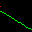

right expected, left(1) found with score 0.753594 (MyFoler\train\right\47_a6.png)


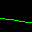

right expected, ok(2) found with score 0.785639 (MyFoler\train\right\54_a8.png)


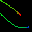

right expected, left(1) found with score 0.822109 (MyFoler\train\right\56_a4.png)


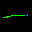

right expected, left(1) found with score 0.776308 (MyFoler\train\right\72_a9.png)


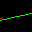

right expected, left(1) found with score 0.856476 (MyFoler\train\right\83_a0.png)


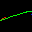

up expected, ok(2) found with score 0.840606 (MyFoler\train\up\51_a3.png)


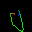

up expected, ok(2) found with score 0.840225 (MyFoler\train\up\51_a4.png)


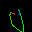

up expected, down(0) found with score 0.762544 (MyFoler\train\up\72_a3.png)


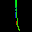

99.5% correct (N=4651, 255 unknown)


In [19]:
print(TEST_FOLDER)
calc_score(model, predict_image, TEST_FOLDER)
print(VAL_FOLDER)
calc_score(model, predict_image, VAL_FOLDER)
print(TRAIN_FOLDER)
calc_score(model, predict_image, TRAIN_FOLDER)

In [20]:
model.save(SAVED_MODEL_PATH)

INFO:tensorflow:Assets written to: MyFoler\saved_model\assets


In [21]:
#!curl -L https://storage.googleapis.com/download.tensorflow.org/models/tflite/micro/magic_wand_saved_model_2021_01_02.tgz -o saved_model.tgz
#!tar -xzf saved_model.tgz

In [22]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_PATH, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob(TEST_FOLDER+os.sep+"*"+os.sep+"*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_PATH, "wb").write(model_tflite)

30536

In [23]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)
  
  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

In [24]:
import time
start_time = time.time()
index, score = predict_image(model, os.path.join(TEST_FOLDER,"left","2.png"))
print("predict:", index, "score:", score*100)
end_time = time.time()
print(end_time-start_time)

predict: 1 score: 92.82989501953125
0.03447556495666504


down expected, ok(2) found with score 0.972656 (MyFoler\test\down\6_a1.png)


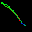

right expected, left(1) found with score 0.910156 (MyFoler\test\right\5_a5.png)


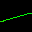

right expected, left(1) found with score 0.750000 (MyFoler\test\right\5_a6.png)


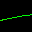

right expected, left(1) found with score 0.882812 (MyFoler\test\right\5_a7.png)


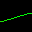

99.3% correct (N=586, 19 unknown)


In [25]:
calc_score(model_tflite, predict_tflite, TEST_FOLDER)

In [26]:
import os
import pandas as pd

def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_PATH)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_PATH)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_PATH)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,664273 bytes,
TensorFlow Lite,98796 bytes,(reduced by 565477 bytes)
TensorFlow Lite Quantized,30536 bytes,(reduced by 68260 bytes)


## The following code will convert to TFLM

In [27]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_PATH} > {TFL_CC_MODEL_PATH}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_PATH.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_PATH}

'apt-get' 不是內部或外部命令、可執行的程式或批次檔。
'xxd' 不是內部或外部命令、可執行的程式或批次檔。
'sed' 不是內部或外部命令、可執行的程式或批次檔。


In [28]:
# Print the C source file
!tail {TFL_CC_MODEL_PATH}

'tail' 不是內部或外部命令、可執行的程式或批次檔。
